In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Must be before importing keras!
import sys
sys.path.insert(0,"/home/kal/CTCF/modules/")
sys.path.insert(0,"/home/kal/CTCF/mass_CTCF/modules/")
import tf_memory_limit
from keras import backend as K
import numpy as np
import matplotlib.cm as cm
from itertools import zip_longest

import ctcfgen
from convnet import Bias
from keras.models import load_model
import matplotlib.pyplot as plt

from scipy.special import logit
from scipy.special import expit as sigmoid
from scipy.signal import correlate2d


# import seqlogo generator
import sys
sys.path.append('/home/thouis/tfmotif/H3K27ac_ANALYSIS')
import viz_sequence

batch_size=32
input_window=256
colors = {0:'crimson', 1:'steelblue', 2:'goldenrod', 3:'forestgreen'}


gen_path='/home/kal/data/ctcfgen_data.hdf5'
#model_path = '/home/kal/CTCF/mass_CTCF/output/20170630_173919/20170630_173919_weights__289_0.95.hdf5'
model_path = '/home/kal/CTCF/mass_CTCF/eric_output/20170731_014309/20170731_014309_weights_3_00_0.90.hdf5'
meme_path = '/home/kal/data/CTCF.meme'


Using TensorFlow backend.


In [2]:
# load the model
model = load_model(model_path, custom_objects={'Bias':Bias})

# load the generator
gen = ctcfgen.CTCFGeneratorhdf5(gen_path)

# get the symbolic outputs of each "key" layer.
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [3]:
def softmax(batch):
    norm_batch = []
    for seq in batch:
        norm_batch.append([_softmax(base) for base in seq])
    return np.asarray(norm_batch)
    
def _softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

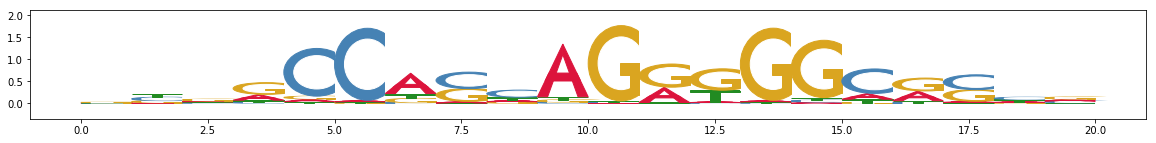

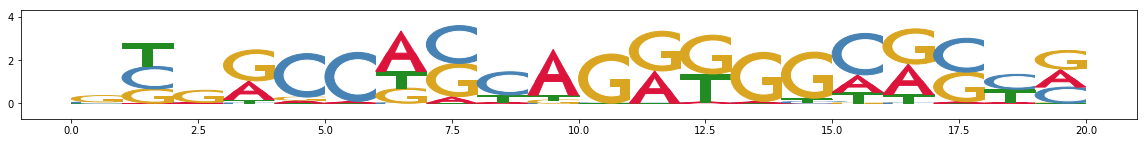

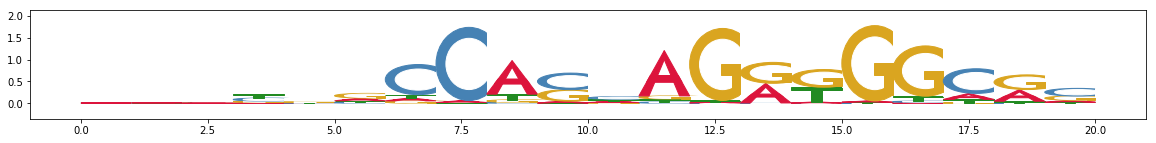

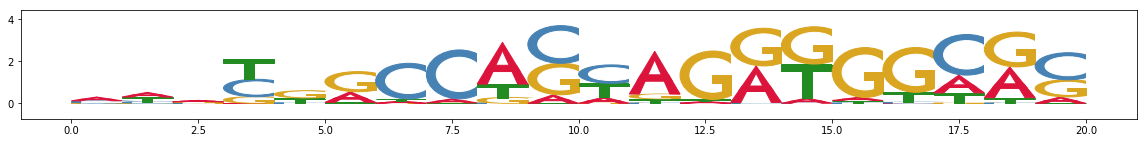

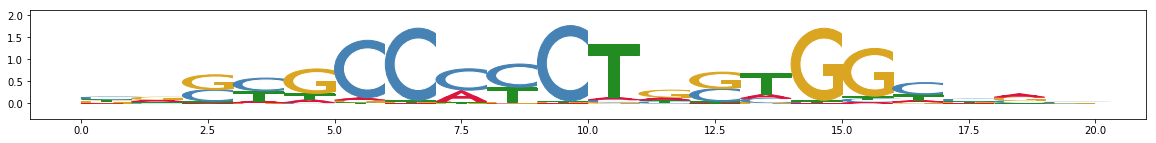

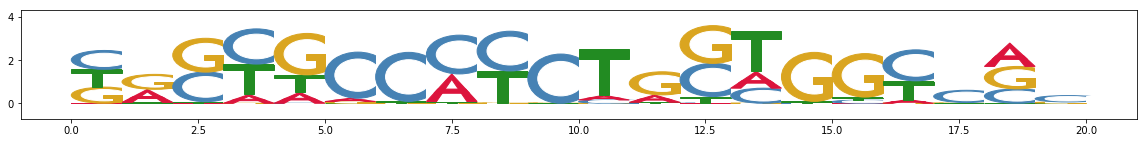

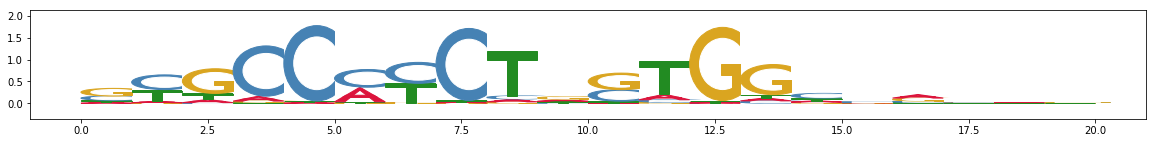

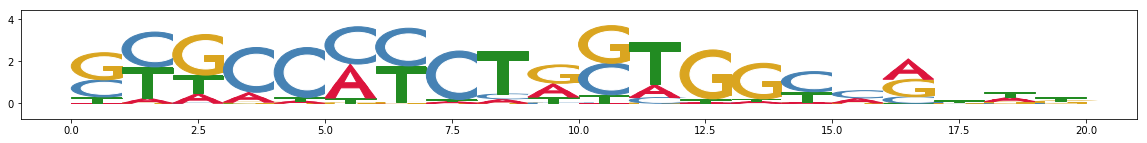

In [4]:
# process the memes
with open(meme_path, 'r') as infile:
    meme_length = -1
    CTCF_memes = list()
    for line in infile.readlines():
        if 'letter-probability matrix' in line:
            meme_length = int(line.split()[5])
            this_meme_lines = list()
        elif meme_length > 0:
            this_meme_lines.append([float(item.strip()) for item in line.split()])
            meme_length = meme_length - 1
        elif meme_length == 0:
            this_meme = np.asarray(this_meme_lines)
            CTCF_memes.append(this_meme)
            meme_length = -1
    if meme_length == 0:
        this_meme = np.asarray(this_meme_lines)
        CTCF_memes.append(this_meme)
        meme_length = -1
        
# add rcs of memes
rcs = list()
for meme in CTCF_memes:
    rcs.append(meme[::-1, ::-1])
CTCF_memes = CTCF_memes + rcs
    
    
psuedocount=0.1
# get the transformed memes
transformed_memes = list()
for meme in CTCF_memes:
    viz_sequence.plot_icweights(meme, colors=colors)
    # add psuedo count
    #print('MEME:')
    #viz_sequence.plot_weights(meme)
    meme = meme + psuedocount 
    #viz_sequence.plot_weights(meme)
    # normalize
    #print('normalized:')
    norms = np.repeat(np.linalg.norm(meme, axis=1), 4).reshape((-1, 4))
    meme = meme/norms
    # log transform
    #print('Log transformed')
    meme = np.log(meme)
    #viz_sequence.plot_weights(meme)
    # shift up
    #print('shift')
    min = np.repeat(np.amin(meme, axis=1),4).reshape(-1, 4)
    meme = meme - min
    viz_sequence.plot_weights(meme, colors=colors)
    transformed_memes.append(meme)
    

def get_pwm(input_seqs, meme=None, position=None, meme_library=transformed_memes, get_score=False):  
    # get position and meme if not specified
    if meme == None and position == None:
        get_loc = True
        for seq in input_seqs:
            best_score = -np.inf
            for test_meme in meme_library:
                correlations = correlate2d(seq, test_meme, mode='valid')
                if np.max(correlations) > best_score:
                    best_score = np.max(correlations)
                    best_location = np.argmax(correlations)
                    best_filter = test_meme
        position = best_location
        meme = best_filter
    else:
        get_loc = False
    
    # get the pwms
    output_scores = list()
    pwm = np.zeros(input_seqs[0].shape)
    pwm[position:position+meme.shape[0]] = meme
    for seq in input_seqs:
        output_scores.append(np.copy(pwm))    
    
    if get_score:
        corr = correlate2d(seq[position:position+meme.shape[0]], meme, mode='valid')
        print('PWM score:' + str(np.max(corr)))
        return np.asarray(output_scores), np.max(corr)
            
    if get_loc:
        return np.asarray(output_scores), meme, position
    else:
        return np.asarray(output_scores)

In [5]:
def act_mutagenisis(seq):
    get_act = K.function([model.input, K.learning_phase()], [layer_dict['bias'].output])

    # do a mutant scan
    mutant_window=1

    # get a mutant batch generator
    mutant_gen = ctcfgen.ngram_mutant_gen(seq, n=mutant_window)
    g = ctcfgen.filled_batch(mutant_gen, batch_size=batch_size)
    
    # base importances as large-step gradients
    # score with base there - average of scores without base there
    mutant_preds = list()
    for batch in g:
        mutant_preds.append(get_act([batch, 0])[0])

    return np.asarray(mutant_preds).reshape((-1, 4))  

In [6]:
def mutagenisis(seq):
    # do a mutant scan
    mutant_window=1

    # get a mutant batch generator
    mutant_gen = ctcfgen.ngram_mutant_gen(seq, n=mutant_window)
    g = ctcfgen.filled_batch(mutant_gen, batch_size=batch_size)
    
    # base importances as large-step gradients
    # score with base there - average of scores without base there
    mutant_preds = list()
    for batch in g:
        mutant_preds.append(model.predict_on_batch(batch))

    return np.asarray(mutant_preds).reshape((-1, 4))  

In [7]:
def get_importance(seq, model, start=None, end=None, plot=True):
    get_act = K.function([model.input, K.learning_phase()], [layer_dict['bias'].output])

    pred = model.predict(np.asarray([seq]*32))[0][0]
    score = get_act([[seq]*32, 0])[0][0][0]
    print('Prediction ' + str(pred))

    mutant_preds = act_mutagenisis(seq)
      
    diffs = mutant_preds - score
   
    all_diffs = list()
    for base_seq, base_preds in zip(seq, mutant_preds):
        this_base = list()
        for idx in range(4):
            this_base.append(base_preds[idx] - np.average(base_preds))
        all_diffs.append(list(this_base))

    all_diffs=np.asarray(all_diffs)

    score_diff = list()
    for base_seq, base_preds in zip(seq, mutant_preds):
        idx = np.where(base_seq)
        score_diff.append(base_preds[idx] - np.average(base_preds))
      
    score_diff = (seq * score_diff)
    
    if plot:
        # plot the gain-loss curve 
        plt.figure(figsize=(30,2.5))

        plt.plot(np.amax(diffs, axis=1)[start:end])
        plt.plot(np.amin(diffs, axis=1)[start:end])
        plt.title('Prediciton Difference for a Mutagenisis Scan')
        plt.ylabel('importance (difference)')
        plt.xlabel('nucleotide')
        plt.show()
    
    print('Prediciton Difference')
    viz_sequence.plot_weights(all_diffs[start:end], colors=colors)

    print('Masked average prediciton difference')
    viz_sequence.plot_weights(score_diff[start:end], colors=colors)

    #print('Softmax average prediction difference')
    #viz_sequence.plot_icweights(softmax([all_diffs[start:end]])[0], colors=colors)

In [8]:
def get_insertions(seq, model, plot=False, start=0, end=256):# interstion mutagenisis
    n=1
    # get a batch generator
    insert_gen = ctcfgen.indel_mutant_gen(seq, n=n)
    f = ctcfgen.filled_batch(insert_gen, batch_size=batch_size)

    #make predictions
    preds = list()
    get_act = K.function([model.input, K.learning_phase()], [layer_dict['bias'].output])
    score = get_act([[seq]*32, 0])[0][0][0]
    for batch in f:
        preds.append(get_act([batch, 0]))

    preds = np.asarray(preds).reshape((-1))

    # shape the predictions into something meaningful
    insertions = preds[:input_window*4].reshape((-1,4))
    deletions = preds[input_window*4:]


    deletions = deletions - score
    insertions = insertions - score
   
    ins_diffs = list()
    for base_seq, base_preds in zip(seq, insertions):
        this_base = list()
        for idx in range(4):
            this_base.append(base_preds[idx] - np.average(base_preds))
        ins_diffs.append(list(this_base))
 
    ins_diffs=np.asarray(ins_diffs)
    
    score_diff = (seq * np.expand_dims(deletions, axis=1))

    if plot:
        # plot the gain-loss curve 
        plt.figure(figsize=(30,2.5))
        plt.plot(np.amax(ins_diffs, axis=1)[start:end])
        plt.plot(np.amin(ins_diffs, axis=1)[start:end])
        plt.title('Prediciton Difference for an Insertion Scan')
        plt.ylabel('insertion difference')
        plt.xlabel('nucleotide')
        plt.show()

        # plot the gain-loss curve 
        plt.figure(figsize=(30,2.5))
        plt.plot(deletions[start:end])
        plt.title('Prediciton Difference for a Deletion Scan')
        plt.ylabel('deletion difference')
        plt.xlabel('nucleotide')
        plt.show()
        
    print('Insertion Difference')
    viz_sequence.plot_weights(ins_diffs[start:end], colors=colors)
    
    print('Deletion Difference')
    viz_sequence.plot_weights(score_diff[start:end], colors=colors)

In [9]:
def get_double(seq, model, start=0, end=256):
    n=1
    # get a batch generator
    insert_gen = ctcfgen.double_mutant_gen(seq, n=n)
    f = ctcfgen.filled_batch(insert_gen, batch_size=batch_size)

    #make predictions
    preds = list()
    get_act = K.function([model.input, K.learning_phase()], [layer_dict['bias'].output])
    score = get_act([[seq]*32, 0])[0][0][0]
    for batch in f:
        preds.append(get_act([batch, 0]))

    preds = np.asarray(preds).reshape((-1))
    preds = preds - score
    preds = preds.reshape((256,4,256,4))
    preds= preds[start:end, :, start:end, :]
    
    # get max or min difference
    maxes = np.amax(np.amax(preds, axis=3), axis=1)
    mins = np.amin(np.amin(preds, axis=3), axis=1)
    
    nets = np.where(abs(maxes)>= abs(mins), maxes, mins)
    
    # plot the maximum difference 
    im = plt.imshow(maxes, cmap='plasma', vmin=-5, vmax=5)
    plt.colorbar(im)
    plt.title('Gain for Double Mutagenisis of a Sequence')
    plt.ylabel('Location of Second Mutation')
    plt.xlabel('Location of First Mutation')
    plt.show()

    # plot the minimum difference 
    im = plt.imshow(mins, cmap='plasma', vmin=-5, vmax=5)
    plt.colorbar(im)
    plt.title('Loss for Double Mutagenisis of a Sequence')
    plt.ylabel('Location of Second Mutation')
    plt.xlabel('Location of First Mutation')
    plt.show()
    
    # plot the net difference 
    im = plt.imshow(nets, cmap='plasma', vmin=-5, vmax=5)
    plt.colorbar(im)
    plt.title('Change for Double Mutagenisis of a Sequence')
    plt.ylabel('Location of Second Mutation')
    plt.xlabel('Location of First Mutation')
    plt.show()
    
    # plot the normalize difference
    seq_len = end-start
    repreds = preds.reshape((seq_len,4,-1))
    normalizations = repreds[:,:,0]
    norm1 = np.repeat(normalizations, (seq_len*4)).reshape((seq_len,4,seq_len,4))
    norm2 = np.rot90(norm1, axes=(0,2))
    
    normalizations = (norm1 + norm2)
    nma = np.amax(np.amax(normalizations, axis=3), axis=1)
    nmi = np.amin(np.amin(normalizations, axis=3), axis=1)
    norms = np.where(abs(nma)>= abs(nmi), nma, nmi)

    norm_preds = preds
    
    nmaxes = np.amax(np.amax(norm_preds, axis=3), axis=1)
    nmins = np.amin(np.amin(norm_preds, axis=3), axis=1)
    norm_nets = np.where(abs(nmaxes)>= abs(nmins), nmaxes, nmins)
   

    # plot the net difference 
    im = plt.imshow(norms, cmap='plasma', vmin=-5, vmax=5)
    plt.colorbar(im)
    plt.title('Normalization for Double Mutagenisis of a Sequence')
    plt.ylabel('Location of Second Mutation')
    plt.xlabel('Location of First Mutation')
    plt.show()
    
    # plot the maximum difference 
    im = plt.imshow(maxes - nma, cmap='plasma', vmin=-5, vmax=5)
    plt.colorbar(im)
    plt.title('Corrected Gain for Double Mutagenisis of a Sequence')
    plt.ylabel('Location of Second Mutation')
    plt.xlabel('Location of First Mutation')
    plt.show()

    # plot the minimum difference 
    im = plt.imshow(mins - nmi, cmap='plasma', vmin=-5, vmax=5)
    plt.colorbar(im)
    plt.title('Corrected Loss for Double Mutagenisis of a Sequence')
    plt.ylabel('Location of Second Mutation')
    plt.xlabel('Location of First Mutation')
    plt.show()
  
    im = plt.imshow(norm_nets - norms, cmap='plasma', vmin=-5, vmax=5)
    plt.colorbar(im)
    plt.title('Corrected Change for Double Mutagenisis of a Sequence')
    plt.ylabel('Location of Second Mutation')
    plt.xlabel('Location of First Mutation')
    plt.show()
    
    return preds

In [20]:
p = gen.pos_training_gen()
seq = ctcfgen.encode(next(p))

Prediction 0.993058


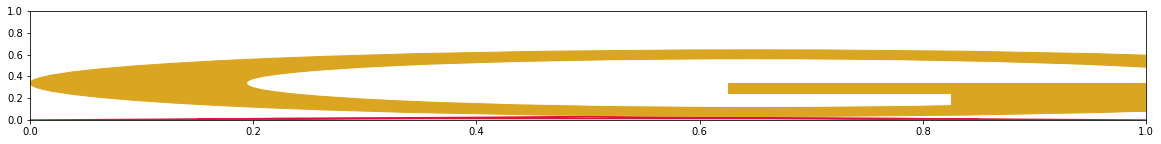

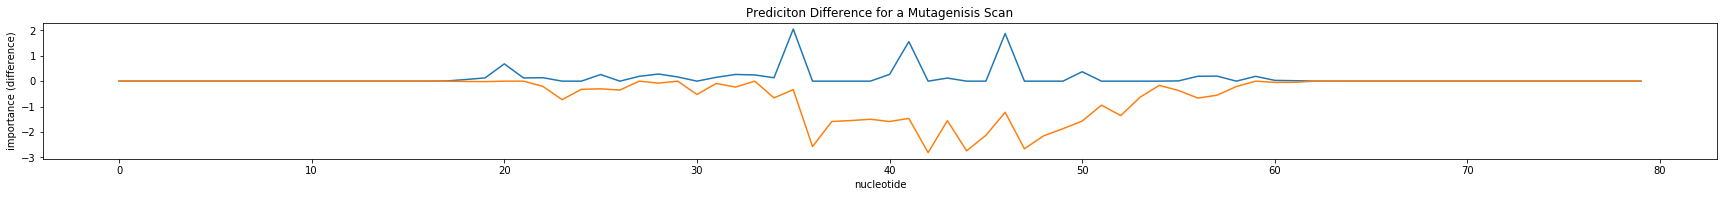

Prediciton Difference


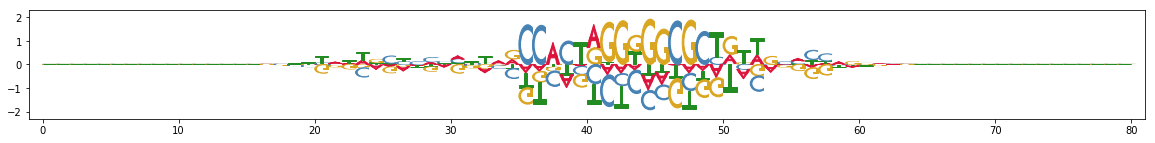

Masked average prediciton difference


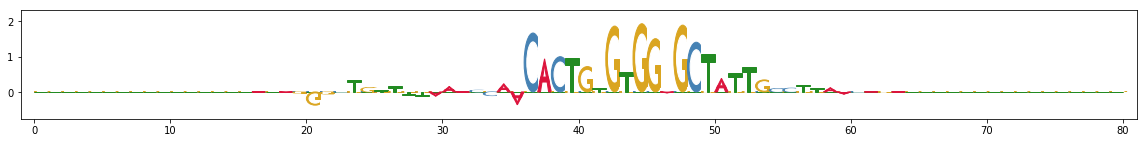

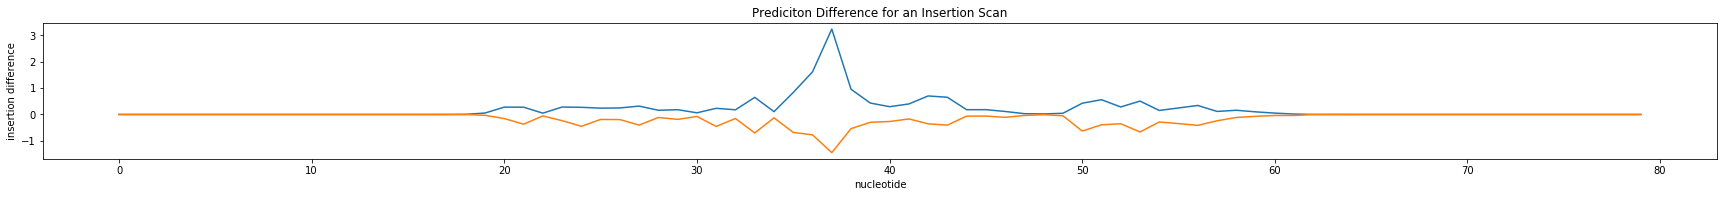

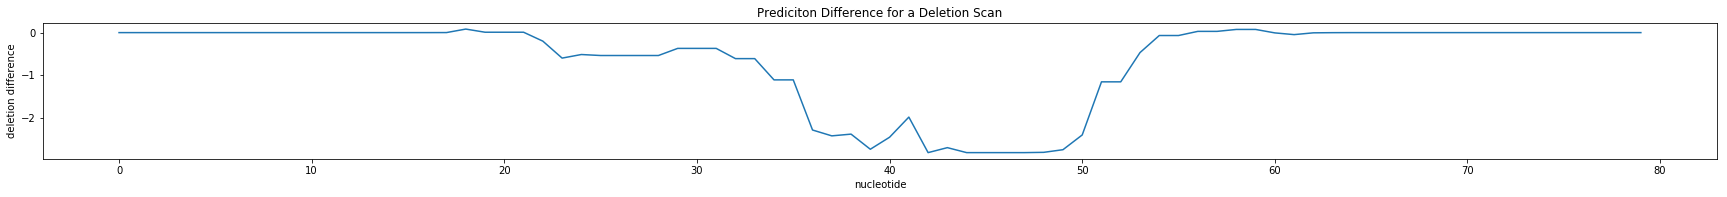

Insertion Difference


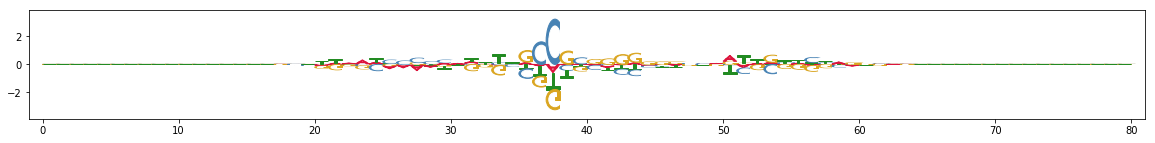

Deletion Difference


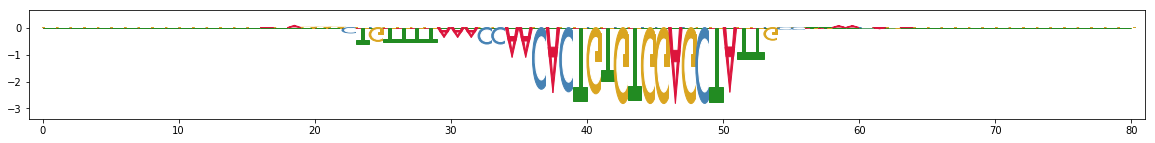

In [21]:
get_importance(seq, model, plot=True, start=100, end=180)
get_insertions(seq, model, plot=True, start=100, end=180)

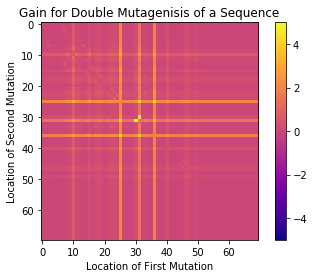

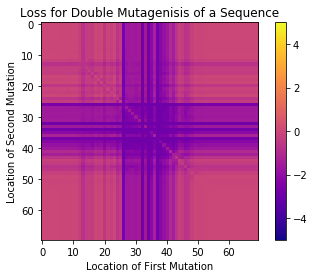

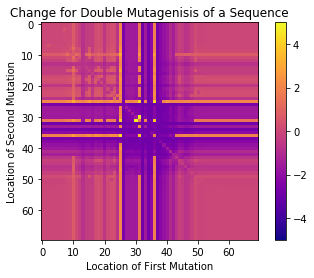

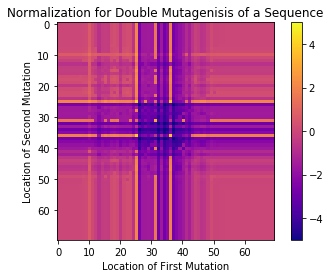

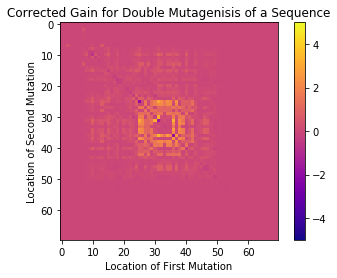

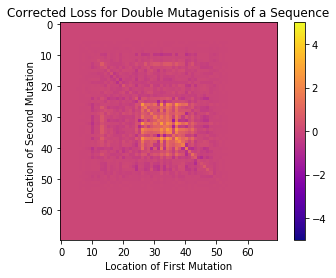

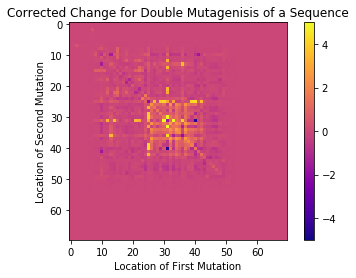

In [22]:
preds = get_double(seq, model, start = 110, end=180)

In [ ]:
# make sure its a well behaved prediction.
get_last_output = K.function([model.layers[0].input, K.learning_phase()], 
                                  [model.layers[-1].output])
score = get_last_output([ctcfgen.blank_batch(seq, batch_size), 0])[0][0][0]
print(score)

mutant_preds = mutagenisis(seq)
      
logit_preds = np.asarray(logit(mutant_preds))
logit_max = logit(score)
print(logit_max)
if logit_max == np.inf:
    logit_max = np.nanmax(logit_preds[np.where(np.isfinite(logit_preds))])

diffs = logit_preds - logit_max
orig_diffs = diffs

for x in np.nditer(diffs, op_flags=['readwrite']):
    if x == np.inf:
        x[...] = np.nanmax(diffs[np.where(np.isfinite(diffs))])

# plot the gain-loss curve 
plt.plot(np.amax(diffs, axis=1))
plt.plot(np.amin(diffs, axis=1))
plt.title('Prediciton Difference for a Mutagenisis Scan')
plt.ylabel('importance (difference)')
plt.xlabel('nucleotide')
plt.show()

seq_center = np.argmax(np.max(abs(diffs), axis=1), axis=0)
# plot the gain-loss curve 
plt.figure(figsize=(30,2.5))
plt.plot(np.amax(diffs, axis=1)[seq_center-45:seq_center+45])
plt.plot(np.amin(diffs, axis=1)[seq_center-45:seq_center+45])
plt.title('Prediciton Difference for a Mutagenisis Scan')
plt.ylabel('importance (difference)')
plt.xlabel('nucleotide')
plt.show()

In [ ]:
viz_sequence.plot_weights(seq[seq_center-45:seq_center+45], colors=colors)


# plot the gain-loss curve 
plt.figure(figsize=(30,2.5))
plt.plot(np.amax(diffs, axis=1)[seq_center-45:seq_center+45])
plt.plot(np.amin(diffs, axis=1)[seq_center-45:seq_center+45])
plt.title('Prediciton Difference for a Mutagenisis Scan')
plt.ylabel('importance (difference)')
plt.xlabel('nucleotide')
plt.show()




In [ ]:
encoded_seq = model.input
get_grads = K.function([encoded_seq, K.learning_phase()], K.gradients(model.output, encoded_seq))
grads = get_grads([ctcfgen.blank_batch(seq, batch_size=32), 0])[0][0]

In [ ]:
colors = {0:'crimson', 1:'steelblue', 2:'goldenrod', 3:'forestgreen'}

print('Starting sequence')
viz_sequence.plot_icweights(seq[seq_center-45:seq_center+45], colors=colors)
print('Gradients')
viz_sequence.plot_weights(grads[seq_center-45:seq_center+45], colors=colors)
print('Differences')
viz_sequence.plot_weights(orig_diffs[seq_center-45:seq_center+45], colors=colors)

# visualize predicitons
print('Softmax Prediction differences')
_ = viz_sequence.plot_icweights(np.asarray([_softmax(base*10) for base in sigmoid(diffs)])[seq_center-45:seq_center+45], colors=colors)
print('Masked Softmax Prediction differnece')
_ = viz_sequence.plot_icweights((seq*np.asarray([_softmax(base*10) for base in sigmoid(diffs)]))[seq_center-45:seq_center+45], colors=colors)

In [ ]:
# plot the score differenece? 
preds = np.copy(mutant_preds)
for x in np.nditer(preds, op_flags=['readwrite']):
    if x == np.inf:
        x[...] = np.nanmax(preds[np.where(np.isfinite(preds))])

all_diffs = list()
for base_seq, base_preds in zip(seq, logit_preds):
    this_base = list()
    for idx in range(4):
        this_base.append(base_preds[idx] - np.average(base_preds))
    all_diffs.append(list(this_base))

all_diffs=np.asarray(all_diffs)

print('Average prediction difference')    
viz_sequence.plot_weights(all_diffs[seq_center-45:seq_center+45], colors=colors)

score_diff = list()
for base_seq, base_preds in zip(seq, logit_preds):
    idx = np.where(base_seq)
    score_diff.append(base_preds[idx] - np.average(base_preds))
      
score_diff = (seq * score_diff)
print('Masked average prediciton difference')
viz_sequence.plot_weights(score_diff[seq_center-45:seq_center+45], colors=colors)

print('Masked softmax average prediciton difference')
viz_sequence.plot_icweights(np.multiply(seq, softmax([all_diffs])[0])[seq_center-45:seq_center+45], colors=colors)

print('Softmax average prediction difference')
_ = viz_sequence.plot_icweights(softmax([all_diffs])[0][seq_center-45:seq_center+45], colors=colors)

In [ ]:
def plot_key(seq, key_values, alpha=.6, background=0):
    cmap = cm.get_cmap('coolwarm')
    highlights=dict()
    
    for base, idx in zip(key_values, range(key_values.shape[0])):
        c = cmap(base)
        if base == background:
            new_color = (c[0], c[1], c[2], 0)
        else: 
            new_color = (c[0], c[1], c[2], alpha)
        try:
            highlights[new_color].append([idx, idx+1])
        except KeyError:
            highlights[new_color] = [[idx, idx+1]]
    
    colors = {0:'crimson', 1:'steelblue', 2:'goldenrod', 3:'forestgreen'}
    
    viz_sequence.plot_weights(seq, highlight=highlights, colors=colors)
    plt.show()

In [ ]:
plot_key(seq[seq_center-45:seq_center+45], np.amax(diffs, axis=1)[seq_center-45:seq_center+45], alpha=.5)
plot_key(seq[seq_center-45:seq_center+45], np.amin(diffs, axis=1)[seq_center-45:seq_center+45], alpha=.5)

plot_key(score_diff[seq_center-45:seq_center+45], np.amax(diffs, axis=1)[seq_center-45:seq_center+45], alpha=.3)

In [ ]:
from itertools import product
ngrams = product(one_hots, repeat=n)

In [ ]:
#write out a file
with open(os.path.join(out_dir, 'ngram_mutants_' + str(mutant_window) + '.fa'), 'w') as output:
    output.write('>predictions\nsequence\n')
    for batch in g:
        preds = model.predict_on_batch(batch)
        seqs = [ctcfgen.decode(mutant_seq).tostring().decode('UTF-8') for mutant_seq in batch]
        for pair in zip(preds, seqs):
            output.write('>'+str(pair[0][0]) + '\n' + pair[1] + '\n')
        